### **1. Data Exploration**

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  12

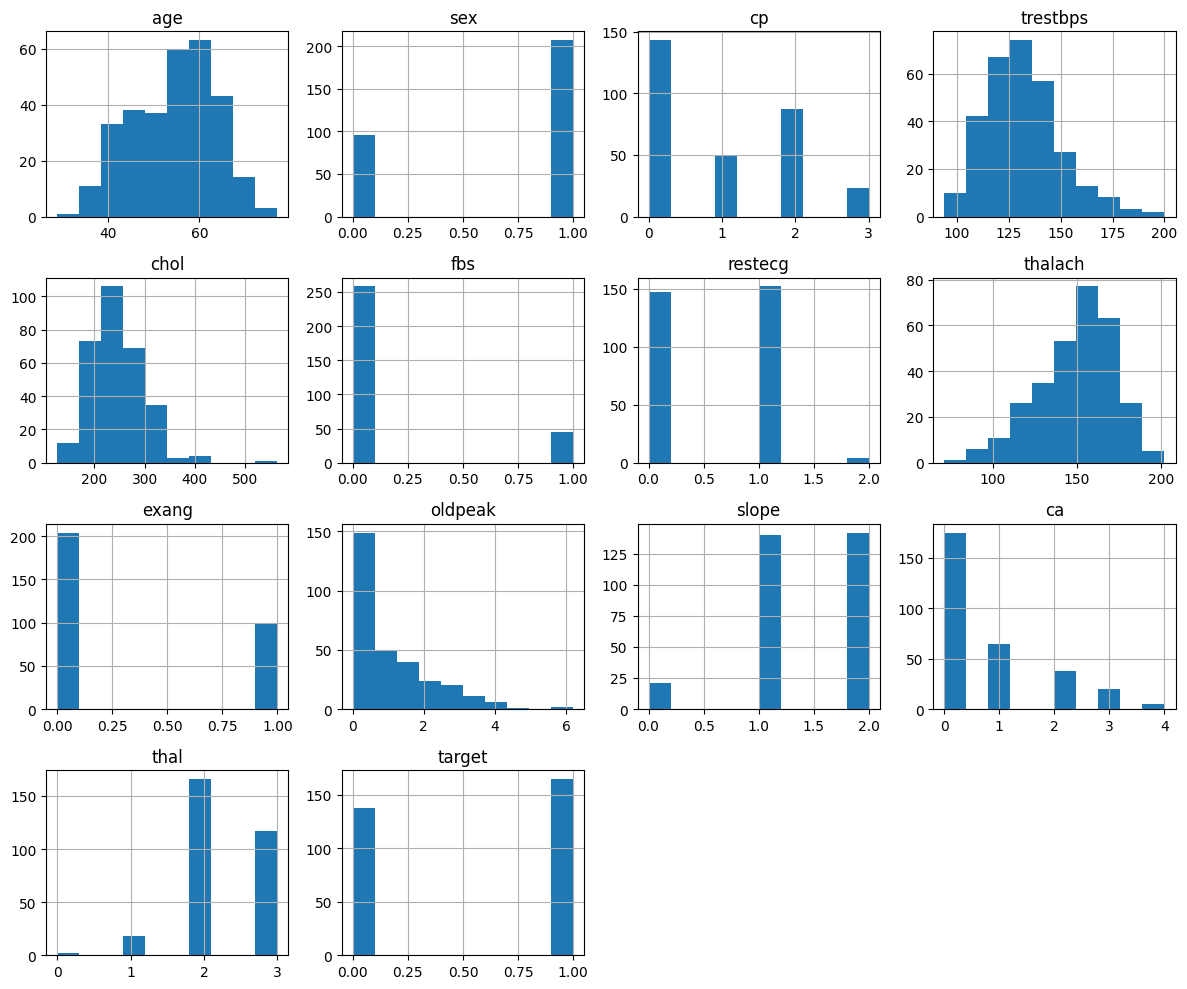

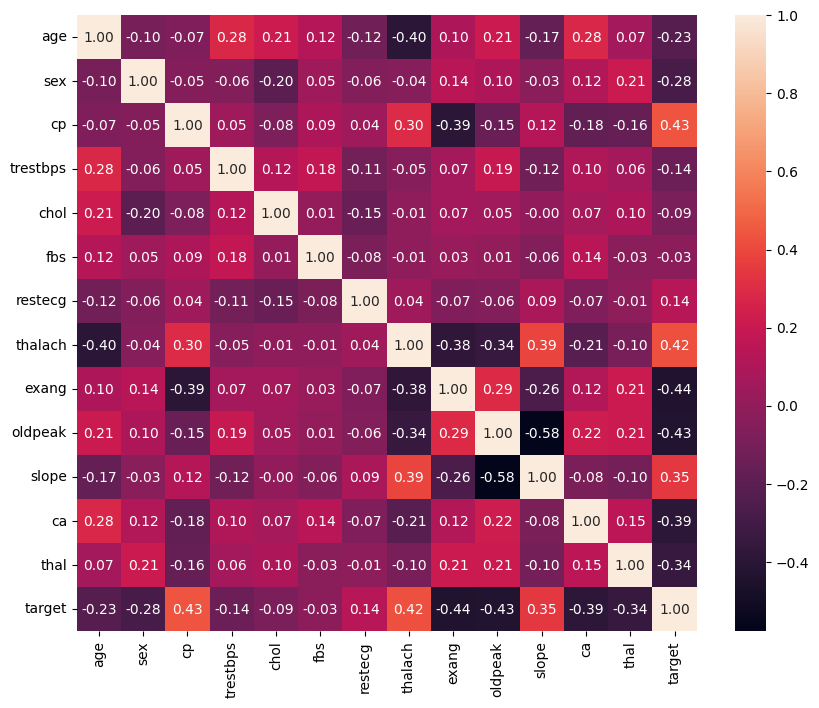

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('heart_data.csv')

# Display first 5 rows
print(df.head())

# generate statistical summary
print(df.describe())

# Create histograms for all numerical features
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Generate coorelation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

### **2. Preprocessing the Data**

In [60]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting dataset into features and target
# Only using features that have a strong corelation with target attribute
X = df[['cp','thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
y = df['target']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Z-Score Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **3. Building Classification Model**

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

# Defining the neural network model
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 64) # 7 input features, #64 output features
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6890920400619507
Epoch 51, Loss: 0.35421013832092285
Epoch 101, Loss: 0.2666483521461487
Epoch 151, Loss: 0.20621544122695923
Epoch 201, Loss: 0.16284465789794922
Epoch 251, Loss: 0.12532328069210052


### **4. Test the Learned Model**

In [63]:
# Make Predictions
from sklearn.metrics import roc_auc_score, precision_score, recall_score
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 83.52%
AUC: 0.8390
Precision: 0.8889
Recall: 0.8000


## **5. Parameter sensitivity analysis**

Changing Number of Epochs

In [64]:
# DECREASING number of Epochs from 300 to 50
for epoch in range(50): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.09114308655261993
Epoch 11, Loss: 0.08502431958913803
Epoch 21, Loss: 0.07924522459506989
Epoch 31, Loss: 0.07389304041862488
Epoch 41, Loss: 0.06888878345489502


In [65]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 84.62%
AUC: 0.8490
Precision: 0.8913
Recall: 0.8200


In [66]:
# DECREASING number of Epochs to 100
for epoch in range(100): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.06414296478033066


In [67]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 84.62%
AUC: 0.8490
Precision: 0.8913
Recall: 0.8200


In [68]:
# Training loop
for epoch in range(10000): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.03351517394185066
Epoch 101, Loss: 0.020196253433823586
Epoch 201, Loss: 0.013415558263659477
Epoch 301, Loss: 0.009675862267613411
Epoch 401, Loss: 0.007328437641263008
Epoch 501, Loss: 0.0057660117745399475
Epoch 601, Loss: 0.0046265944838523865
Epoch 701, Loss: 0.0037940468173474073
Epoch 801, Loss: 0.0031420323066413403
Epoch 901, Loss: 0.0026569899637252092
Epoch 1001, Loss: 0.0022544253151863813
Epoch 1101, Loss: 0.0019376372219994664
Epoch 1201, Loss: 0.001659530564211309
Epoch 1301, Loss: 0.0014303382486104965
Epoch 1401, Loss: 0.001237942953594029
Epoch 1501, Loss: 0.0010677601676434278
Epoch 1601, Loss: 0.0009327189764007926
Epoch 1701, Loss: 0.0008195608970709145
Epoch 1801, Loss: 0.0007167886360548437
Epoch 1901, Loss: 0.0006315951468423009
Epoch 2001, Loss: 0.0005570414359681308
Epoch 2101, Loss: 0.0004933302407152951
Epoch 2201, Loss: 0.00044034270104020834
Epoch 2301, Loss: 0.0003911394451279193
Epoch 2401, Loss: 0.0003488010261207819
Epoch 2501, Loss: 0

In [69]:

# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 82.42%
AUC: 0.8246
Precision: 0.8542
Recall: 0.8200


Adding More Layers

In [70]:
# Adding 1 additional layer

# Define the neural network model
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 64) # 7 input features
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.700326144695282
Epoch 101, Loss: 0.1882428228855133
Epoch 201, Loss: 0.048652533441782


In [71]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 82.42%
AUC: 0.8246
Precision: 0.8542
Recall: 0.8200


In [72]:
# Removing a layer

# Define the neural network model
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 64) # 7 input features
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.715801477432251
Epoch 101, Loss: 0.3741227388381958
Epoch 201, Loss: 0.32563498616218567


In [73]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 79.12%
AUC: 0.7902
Precision: 0.8163
Recall: 0.8000


Changing Number of Units in each layer

In [74]:
# Using 32 neurons instead of 64
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 32) # 7 input features
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6908395290374756
Epoch 101, Loss: 0.33651989698410034
Epoch 201, Loss: 0.24365288019180298


In [75]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 83.52%
AUC: 0.8368
Precision: 0.8723
Recall: 0.8200


In [76]:
# Using 128 neurons instead of 64
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 128) # 7 input features
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.7126894593238831
Epoch 101, Loss: 0.20327021181583405
Epoch 201, Loss: 0.0748085230588913


In [77]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 84.62%
AUC: 0.8468
Precision: 0.8750
Recall: 0.8400


Changing Activation Function

In [78]:
# # Using Sigmoid as the activation function
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 64) # 7 input features
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.7012835144996643
Epoch 101, Loss: 0.3915311396121979
Epoch 201, Loss: 0.3455306589603424


In [79]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 81.32%
AUC: 0.8124
Precision: 0.8367
Recall: 0.8200


In [80]:
# Using Tanh as the activation function
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(7, 64) # 7 input features
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model & setup loss and optimizer function
model = HeartDiseaseNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to torch tensors
X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)
y_test_torch = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

# Training loop
for epoch in range(300): # number of epochs
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train_torch)

    # Compute loss
    loss = criterion(y_pred, y_train_torch)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6793333888053894
Epoch 101, Loss: 0.3329775333404541
Epoch 201, Loss: 0.2694767117500305


In [81]:
# TESTING ACCURACY
with torch.no_grad():
    y_pred = model(X_test_torch)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test_torch).sum() / float(y_test_torch.shape[0])).item()
    print(f'Accuracy: {accuracy * 100:.2f}%')
    y_pred_np = y_pred_class.cpu().numpy()
    y_test_np = y_test_torch.cpu().numpy()

    # Calculate AUC
    auc = roc_auc_score(y_test_np, y_pred_np)
    print(f'AUC: {auc:.4f}')

    # Calculate precision
    precision = precision_score(y_test_np, y_pred_np)
    print(f'Precision: {precision:.4f}')

    # Calculate recall
    recall = recall_score(y_test_np, y_pred_np)
    print(f'Recall: {recall:.4f}')

Accuracy: 79.12%
AUC: 0.7924
Precision: 0.8298
Recall: 0.7800
